## Lab: Spectral Methods for the Variable Coefficient Wave Equation

***José Enrique Zafra Mena, Francisco Javier Miró Rodríguez***

### 1\. Introduction

Consider the variable coefficient wave equation:

$$
u_t + c(x)u_x = 0, \quad c(x) = \frac{1}{5} + \sin^2(x-1) \quad (1)
$$

for $x \in [0, 2\pi]$ and $t > 0$, with periodic boundary conditions.

As an initial condition, we take:

$$
u(x,0) = \exp(-100(x-1)^2)
$$

**Note:** This function is not mathematically periodic, but it decays so rapidly toward zero at the ends of the interval that it can be regarded as periodic for numerical purposes.

### 2\. Numerical Discretization

To construct our numerical scheme, we proceed as we might with a finite difference approximation of a PDE.

  * **Time Integration:** We use a **leap-frog** formula.
  * **Spatial Derivative:** We approximate the derivative **spectrally**.

Let $v^{(n)}$ be the vector at time step $n$ that approximates $u(x_j, n\Delta t)$. At grid point $x_j$, our spectral derivative is $(Dv^{(n)})_j$, where $D = D_N$ is the spectral differentiation matrix for the $N$-point equispaced grid. We implement this operation using the Fast Fourier Transform (FFT).

The fully discrete approximation becomes:

$$
\frac{v_j^{(n+1)} - v_j^{(n-1)}}{2\Delta t} = -c(x_j)(Dv^{(n)})_j, \quad j=1, \dots, N.
$$

### 3\. Implementation Details

The formula above represents the core of the implementation. However, there is a complication: the leap-frog scheme requires **two** initial conditions ($v^{(0)}$ and $v^{(1)}$) to start, whereas the PDE provides only one ($u(x,0)$).

To obtain a starting value $v^{(-1)}$ (or $v^{(1)}$), the baseline program below extrapolates backwards under the assumption of a constant wave speed of $c = 1/5$. This approximation introduces a small error.

When running the code, observe the output. You should see a wave propagating at variable speed. Note that there are no ripples emanating from the wave; it remains coherent and clean. Solutions from finite difference discretizations rarely look this distinct. The absence of spurious dispersion is one of the conspicuous advantages of spectral methods.



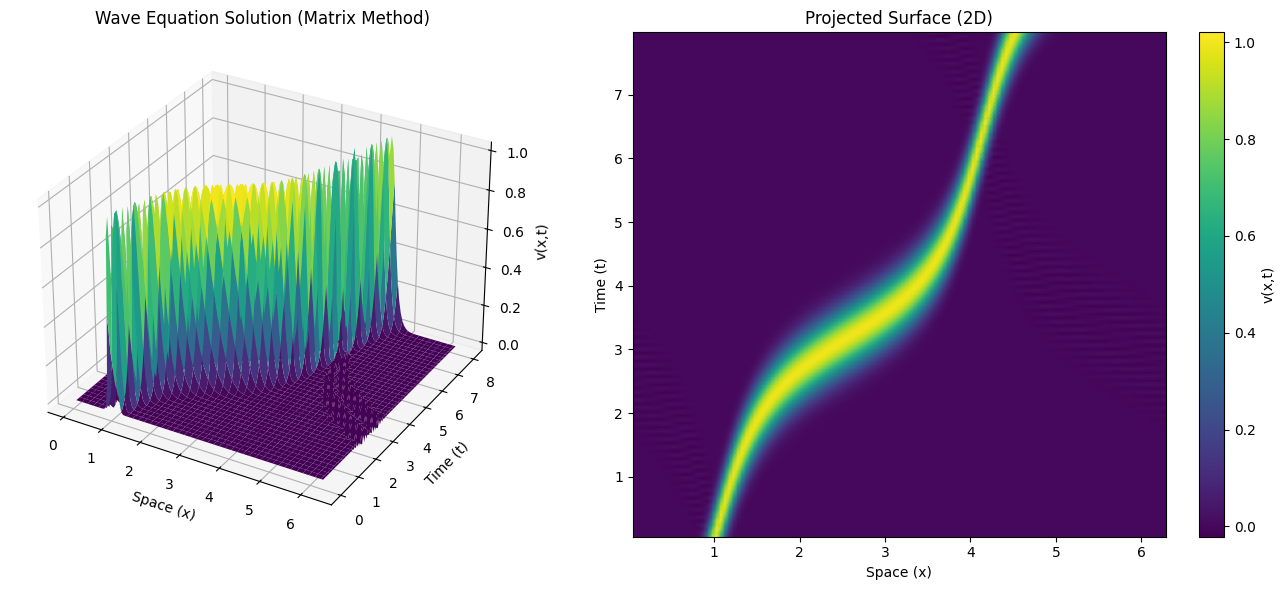

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def solve_wave_eq_fft():

    # Grid, variable coefficient, and initial data
    N = 128
    h = 2 * np.pi / N
    x = h * np.arange(1, N + 1)
    dt = h / 4

    # Variable coefficient c(x)
    c = 0.2 + np.sin(x - 1)**2

    # Initial condition
    v = np.exp(-100 * (x - 1)**2)

    # Previous time step (vold) approximation assuming left-wave propagation
    vold = np.exp(-100 * (x - 0.2 * dt - 1)**2)

    # Time-stepping by leap frog formula
    t = 0
    tmax = 8
    niter = int(tmax / dt)

    data = []
    tn = []

    # Pre-compute wavenumbers for spectral derivative
    # fftshift orders frequencies as [0, 1, ... N/2-1, -N/2, ... -1]
    # which matches the output of fft(v)
    k_vec = np.fft.fftshift(np.arange(-N/2, N/2))

    for n in range(niter):
        t = t + dt

        # Derivative approximation using FFT
        v_hat = np.fft.fft(v)
        w_hat = 1j * k_vec * v_hat
        w = np.real(np.fft.ifft(w_hat))

        # Leap-frog update
        vnew = vold - 2 * dt * c * w

        # Update variables
        vold = v.copy()
        v = vnew.copy()

        # Store data every 5 steps
        if (n + 1) % 5 == 0:
            data.append(vnew.copy())
            tn.append(t)

    # Convert lists to arrays for plotting
    data = np.array(data)
    tn = np.array(tn)

    # Plotting
    X, T = np.meshgrid(x, tn)

    fig = plt.figure(figsize=(14, 6))

    # --- Left: 3D surface ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax1.plot_surface(X, T, data, cmap='viridis', edgecolor='none')
    ax1.set_xlabel('Space (x)')
    ax1.set_ylabel('Time (t)')
    ax1.set_zlabel('v(x,t)')
    ax1.set_title('Wave Equation Solution (Matrix Method)')

    # --- Right: 2D projection ---
    ax2 = fig.add_subplot(1, 2, 2)
    pcm = ax2.pcolormesh(X, T, data, shading='gouraud', cmap='viridis')
    ax2.set_xlabel('Space (x)')
    ax2.set_ylabel('Time (t)')
    ax2.set_title('Projected Surface (2D)')

    fig.colorbar(pcm, ax=ax2, label='v(x,t)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    solve_wave_eq_fft()

### 4\. Exercises

**Exercise 1.** 
For more serious work, one should use one or more steps of a one-step ODE formula (such as a Runge–Kutta formula) to generate the necessary second set of initial data at $t = -\Delta t$ or $t = \Delta t$.

**Task:** Modify the program to implement a Runge-Kutta initialization step.


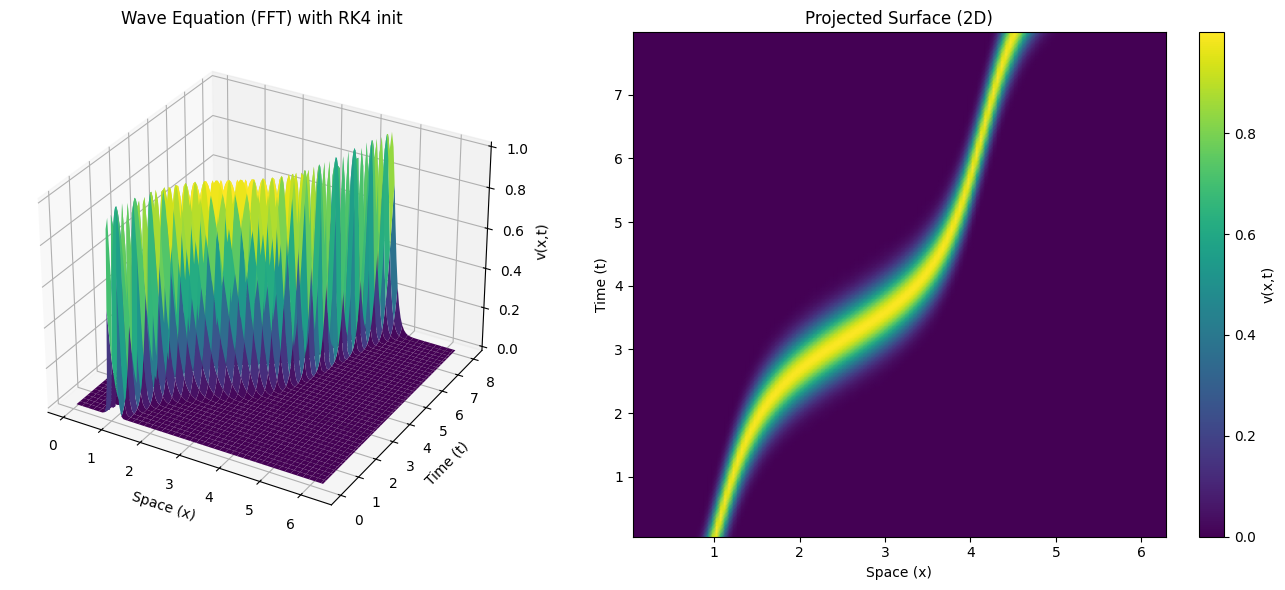

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def k_vector(N: int) -> np.ndarray:
    return np.fft.fftshift(np.arange(-N // 2, N // 2))


def spectral_derivative(v: np.ndarray, k_vec: np.ndarray) -> np.ndarray:
    return np.real(np.fft.ifft(1j * k_vec * np.fft.fft(v)))


def rk4_step(v: np.ndarray, dt: float, rhs):
    k1 = rhs(v)
    k2 = rhs(v + 0.5 * dt * k1)
    k3 = rhs(v + 0.5 * dt * k2)
    k4 = rhs(v + dt * k3)
    return v + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6


def solve_wave_eq_fft_rk_init():
    N = 128
    h = 2 * np.pi / N
    x = h * np.arange(1, N + 1)
    dt = h / 4

    c = 0.2 + np.sin(x - 1) ** 2
    v = np.exp(-100 * (x - 1) ** 2)

    k_vec = k_vector(N)
    rhs = lambda u: -c * spectral_derivative(u, k_vec)

    # RK4 one-step backward in time to seed leap-frog
    vold = rk4_step(v, -dt, rhs)

    t = 0.0
    tmax = 8.0
    niter = int(np.round(tmax / dt))
    data, tn = [], []

    for n in range(niter):
        t += dt
        w = spectral_derivative(v, k_vec)
        vnew = vold - 2 * dt * c * w
        vold, v = v, vnew

        if (n + 1) % 5 == 0:
            data.append(v.copy())
            tn.append(t)

    data, tn = np.array(data), np.array(tn)
    X, T = np.meshgrid(x, tn)

    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax1.plot_surface(X, T, data, cmap='viridis', edgecolor='none')
    ax1.set_xlabel('Space (x)')
    ax1.set_ylabel('Time (t)')
    ax1.set_zlabel('v(x,t)')
    ax1.set_title('Wave Equation (FFT) with RK4 init')

    ax2 = fig.add_subplot(1, 2, 2)
    pcm = ax2.pcolormesh(X, T, data, shading='gouraud', cmap='viridis')
    ax2.set_xlabel('Space (x)')
    ax2.set_ylabel('Time (t)')
    ax2.set_title('Projected Surface (2D)')
    fig.colorbar(pcm, ax=ax2, label='v(x,t)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    solve_wave_eq_fft_rk_init()



--- 

**Exercise 2.**
Recompute the output using a modified program based on **matrix multiplication** rather than the FFT for the differentiation step.

**Task:**

1.  Measure the computation time (exclude plotting time) for both the FFT and Matrix versions.
2.  How much slower or faster is the matrix version?
3.  How does the performance scaling change if $N$ is increased from $128$ to $256$?


N=128 , FFT:  0.0065s , Matrix:  0.0081s , FFT/Matrix =  0.81
N=256 , FFT:  0.0124s , Matrix:  0.0630s , FFT/Matrix =  0.20
N=512 , FFT:  0.0291s , Matrix:  0.4727s , FFT/Matrix =  0.06
N=1024 , FFT:  0.0908s , Matrix:  3.9695s , FFT/Matrix =  0.02


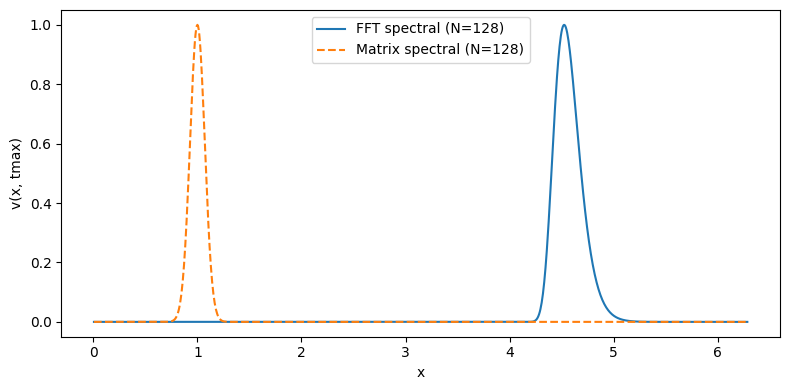

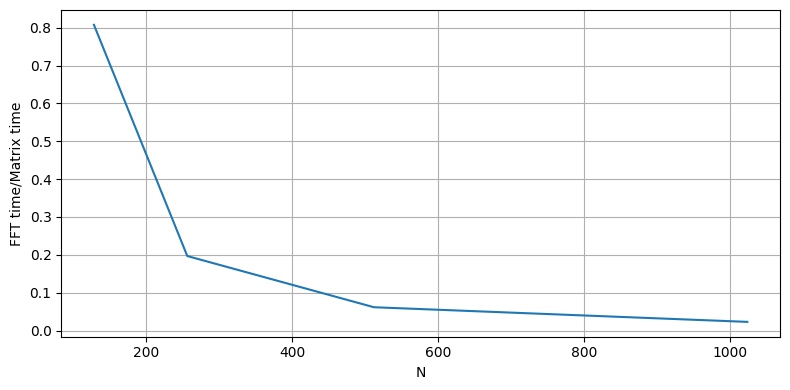

In [22]:
import time

def spectral_derivative_fft(v: np.ndarray, k_vec: np.ndarray) -> np.ndarray:
    return np.real(np.fft.ifft(1j * k_vec * np.fft.fft(v)))


def spectral_matrix(N: int) -> np.ndarray:
    k_vec = k_vector(N)
    F = np.fft.fft(np.eye(N))
    Finv = np.fft.ifft(np.eye(N))
    return np.real(Finv @ (1j * k_vec * F))



def run_solver(N: int, use_matrix: bool, tmax: float = 8.0):
    h = 2 * np.pi / N
    x = h * np.arange(1, N + 1)
    dt = h / 4
    c = 0.2 + np.sin(x - 1) ** 2
    v = np.exp(-100 * (x - 1) ** 2)

    if use_matrix:
        D = spectral_matrix(N)
        deriv = lambda u: np.real(D @ u)
    else:
        k_vec = k_vector(N)
        deriv = lambda u: spectral_derivative_fft(u, k_vec)

    rhs = lambda u: -c * deriv(u)
    vold = rk4_step(v, -dt, rhs)

    niter = int(np.round(tmax / dt))
    tic = time.perf_counter()
    for _ in range(niter):
        w = deriv(v)
        vnew = vold - 2 * dt * c * w
        vold, v = v, vnew
    elapsed = time.perf_counter() - tic
    return x, v, elapsed

results = []
persc = []
N_vals = [128, 256, 512, 1024]
for it, N in enumerate(N_vals):
    x_fft, v_fft, t_fft = run_solver(N, use_matrix=False)
    x_mat, v_mat, t_mat = run_solver(N, use_matrix=True)
    speed = t_fft / t_mat
    results.append((N, t_fft, t_mat, speed))
    persc.append(results[it][1]/results[it][2])
    print(f"N={N:3d} , FFT: {t_fft:7.4f}s , Matrix: {t_mat:7.4f}s , FFT/Matrix = {speed:5.2f}")

plt.figure(figsize=(8, 4))
plt.plot(x_fft, v_fft, label='FFT spectral (N=128)')
plt.plot(x_mat, v_mat, '--', label='Matrix spectral (N=128)')
plt.xlabel('x')
plt.ylabel('v(x, tmax)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(N_vals, persc)
plt.xlabel('N')
plt.ylabel('FFT time/Matrix time')
plt.tight_layout()
plt.grid()
plt.show()



The FFT method is way faster than the matrix method.

When increasing $N$ from 128 to 256:

- FFT method: scales as $\mathcal O(N \log N)$, so the cost grows by  $$\frac{256\log 256}{128\log 128} \approx 2.3.$$

- Matrix method: scales as $\mathcal O(N^2)$, so the cost grows by $$\frac{256^2}{128^2} = 4.$$

Thus, the matrix version becomes relatively slower as $N$ increases.  
This is why the ratio (FFT time / Matrix time) decreases with $N$:  
FFT gets efficient with the problem size, while the matrix approach does not.

In [30]:
256*np.log(256)/128/np.log(128)
256**2/128**2

4.0

--- 

**Exercise 3.**
Recompute the output by a modified program based on the standard finite difference leap-frog formula:
$$
\frac{v_j^{(n+1)} - v_j^{(n-1)}}{2\Delta t} = -c(x_j) \frac{v_{j+1}^{(n)} - v_{j-1}^{(n)}}{2\Delta x}, \quad j=1, \dots, N
$$
**Task:** Produce plots for $N = 128$ and $N = 256$ and compare them to the spectral solution. Comment on the dispersion errors (ripples).


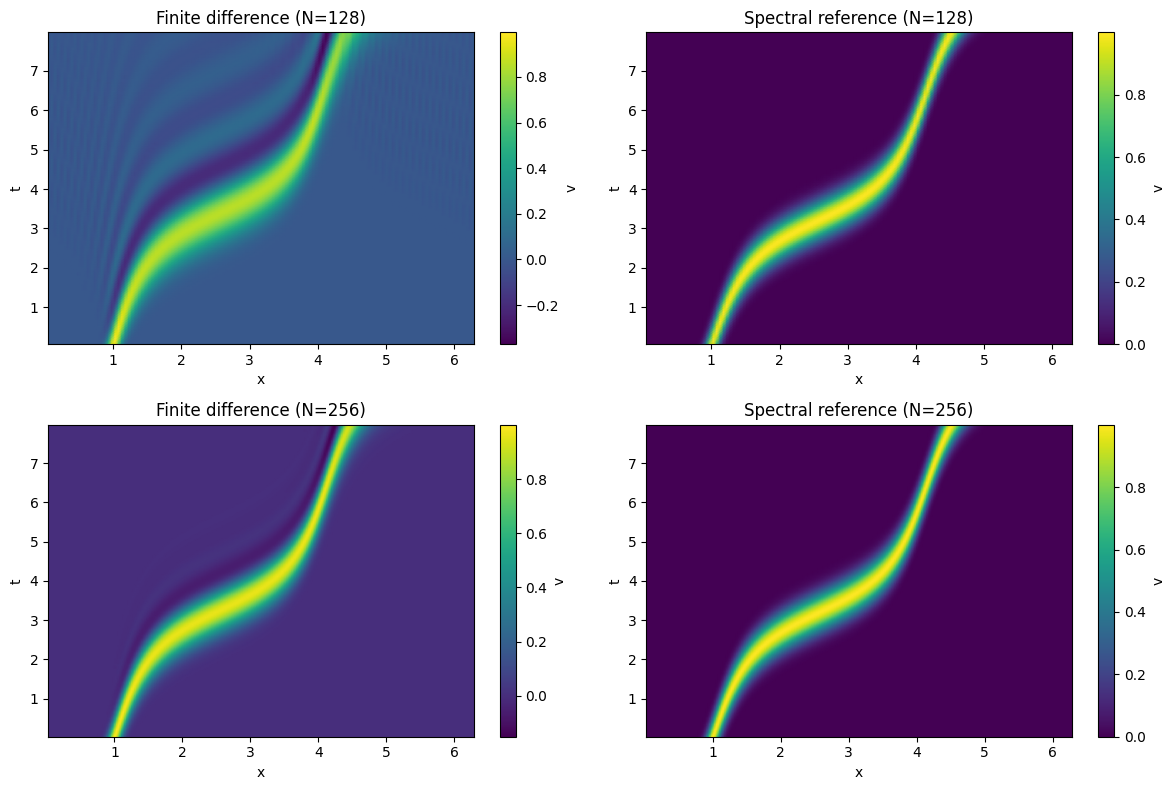

In [36]:
def finite_difference_derivative(v: np.ndarray, h: float) -> np.ndarray:
    return (np.roll(v, -1) - np.roll(v, 1)) / (2 * h)


def solve_wave_fd(N: int, tmax: float = 8.0):
    h = 2 * np.pi / N
    x = h * np.arange(1, N + 1)
    dt = h / 4
    c = 0.2 + np.sin(x - 1) ** 2
    v = np.exp(-100 * (x - 1) ** 2)

    rhs = lambda u: -c * finite_difference_derivative(u, h)
    vold = rk4_step(v, -dt, rhs)

    niter = int(np.round(tmax / dt))
    data, tn = [], []
    for n in range(niter):
        vnew = vold + 2 * dt * rhs(v)
        vold, v = v, vnew
        if (n + 1) % 5 == 0:
            data.append(v.copy())
            tn.append((n + 1) * dt)
    return x, np.array(tn), np.array(data)


def solve_wave_fft(N: int, tmax: float = 8.0):
    h = 2 * np.pi / N
    x = h * np.arange(1, N + 1)
    dt = h / 4
    c = 0.2 + np.sin(x - 1) ** 2
    v = np.exp(-100 * (x - 1) ** 2)
    k_vec = k_vector(N)
    rhs = lambda u: -c * spectral_derivative(u, k_vec)
    vold = rk4_step(v, -dt, rhs)

    niter = int(np.round(tmax / dt))
    data, tn = [], []
    for n in range(niter):
        w = spectral_derivative(v, k_vec)
        vnew = vold - 2 * dt * c * w
        vold, v = v, vnew
        if (n + 1) % 5 == 0:
            data.append(v.copy())
            tn.append((n + 1) * dt)
    return x, np.array(tn), np.array(data)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, N in enumerate((128, 256)):
    x_fd, t_fd, data_fd = solve_wave_fd(N)
    x_sp, t_sp, data_sp = solve_wave_fft(N)

    ax_fd = axes[idx, 0]
    Xfd, Tfd = np.meshgrid(x_fd, t_fd)
    pcm_fd = ax_fd.pcolormesh(Xfd, Tfd, data_fd, shading='gouraud')
    ax_fd.set_title(f'Finite difference (N={N})')
    ax_fd.set_xlabel('x')
    ax_fd.set_ylabel('t')
    fig.colorbar(pcm_fd, ax=ax_fd, label='v')

    ax_sp = axes[idx, 1]
    Xsp, Tsp = np.meshgrid(x_sp, t_sp)
    pcm_sp = ax_sp.pcolormesh(Xsp, Tsp, data_sp, shading='gouraud')
    ax_sp.set_title(f'Spectral reference (N={N})')
    ax_sp.set_xlabel('x')
    ax_sp.set_ylabel('t')
    fig.colorbar(pcm_sp, ax=ax_sp, label='v')

plt.tight_layout()
plt.show()




In the leap–frog scheme, the numerical phase speed does not match the true phase speed of the PDE for all wavelengths. High–frequency components are advected too slowly or too fast, producing numerical dispersion. This dispersion manifests as oscillatory ripples trailing behind the main pulse.

For $N = 128$, the grid is bigger, so high–frequency modes are poorly resolved. Their numerical phase error is larger, and the solution shows clear ripples around the wave front.

For $N = 256$, the spatial resolution improves. High–frequency modes are better represented, the dispersion errors decrease, and the ripples become smaller, although they do not disappear entirely.  
In contrast, the spectral reference solution does not exhibit these artifacts because it has negligible dispersion error.


---

**Exercise 4.**
The solution of Eq. (1) is periodic in time. For a certain period $T \approx 13$, $u(x, T) = u(x, 0)$ for all $x$.

**Task:**
1.  Determine $T$ analytically by evaluating the appropriate integral derived from the method of characteristics.
2.  Modify the program to compute $u(x, T)$ instead of $u(x, 8)$. Ensure $t$ stops *exactly* at $T$, not at a nearby number determined by `np.round` or integer steps.
3.  For $N = 32, 64, \dots, 512$, determine the maximum error: $\max_j |u(x_j, T) - u(x_j, 0)|$.
4.  Plot this error on a log-log scale as a function of $N$.
5.  What is the rate of convergence? How could it be improved?


Analytical period T = 12.825498
N= 32 | max error = 3.708e-01
N= 64 | max error = 7.312e-02
N=128 | max error = 9.407e-03
N=256 | max error = 2.508e-03
N=512 | max error = 6.262e-04
Slope log-log ~ -2.33


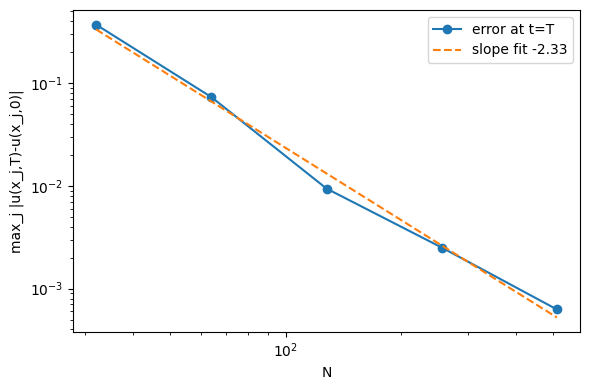

In [41]:

def spectral_solution_at_T(N: int, T: float):
    h = 2 * np.pi / N
    x = h * np.arange(1, N + 1)
    dt_base = h / 4
    steps = int(np.ceil(T / dt_base))
    dt = T / steps  # force final time to land exactly on T

    c = 0.2 + np.sin(x - 1) ** 2
    v = np.exp(-100 * (x - 1) ** 2)
    k_vec = k_vector(N)
    rhs = lambda u: -c * spectral_derivative(u, k_vec)
    vold = rk4_step(v, -dt, rhs)

    for _ in range(steps):
        w = spectral_derivative(v, k_vec)
        vnew = vold - 2 * dt * c * w
        vold, v = v, vnew
    return x, v

T = 10*np.pi/np.sqrt(6)
print(f"Analytical period T = {T:.6f}")

N_values = [32, 64, 128, 256, 512]
errors = []
for N in N_values:
    x, v_T = spectral_solution_at_T(N, T)
    v0 = np.exp(-100 * (x - 1) ** 2)
    err = np.max(np.abs(v_T - v0))
    errors.append(err)
    print(f"N={N:3d} | max error = {err:.3e}")

p = np.polyfit(np.log(N_values), np.log(errors), 1)
rate = p[0]
print(f"Slope log-log ~ {rate:.2f}")

plt.figure(figsize=(6, 4))
plt.loglog(N_values, errors, 'o-', label='error at t=T')
plt.loglog(N_values, np.exp(p[1]) * np.array(N_values) ** rate, '--', label=f'slope fit {rate:.2f}')
plt.xlabel('N')
plt.ylabel('max_j |u(x_j,T)-u(x_j,0)|')
plt.legend()
plt.tight_layout()
plt.show()



This convergence rate ($k^2$) depends on the time solver, in this case the Leap-frog method. To increase the accuracy, we should change the method to another one better, like RK4.